### Objective: Which products will an Instacart consumer purchase next?
#### We'll apply some different models to observe their predictive performance. 

In [1]:
import pandas as pd
import numpy as np
pd.set_option('precision',4)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [4]:
# read in sample datasets
prior_orders_df = pd.read_csv('transformed/prior_order_features_sample.csv')
train_orders_df = pd.read_csv('transformed/train_order_features_sample.csv')

In [7]:
prior_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910693 entries, 0 to 910692
Data columns (total 25 columns):
Unnamed: 0                 910693 non-null int64
order_id                   910693 non-null int64
user_id                    910693 non-null int64
order_number               910693 non-null int64
order_dow                  910693 non-null int64
order_hour_of_day          910693 non-null int64
days_since_prior_order     910693 non-null float64
product_id                 910693 non-null int64
add_to_cart_order          910693 non-null int64
reordered                  910693 non-null int64
aisle_id                   910693 non-null int64
department_id              910693 non-null int64
user_orders                910693 non-null int64
basket_size                910693 non-null int64
avg_basket_size            910693 non-null float64
avg_reorders_per_basket    910693 non-null float64
user_order_dow_mode        910693 non-null int64
user_order_hour_mode       910693 non-null int64
a

In [8]:
train_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830770 entries, 0 to 830769
Data columns (total 16 columns):
Unnamed: 0                 830770 non-null int64
order_id                   830770 non-null int64
product_id                 830770 non-null int64
add_to_cart_order          830770 non-null int64
reordered                  830770 non-null int64
user_id                    830770 non-null int64
order_dow                  830770 non-null int64
order_hour_of_day          830770 non-null int64
days_since_prior_order     830770 non-null float64
avg_reorders_per_basket    830770 non-null float64
avg_basket_size            830770 non-null float64
avg_days_between_orders    830770 non-null float64
prod_reorder_rate          830770 non-null float64
avg_add_to_cart_order      830770 non-null float64
user_prod_reorder_rate     830770 non-null float64
user_prod_reorders         830770 non-null float64
dtypes: float64(8), int64(8)
memory usage: 101.4 MB


Let's take another look at features of importance leaving out 'order_number' and 'user_prod_reorders'

In [5]:
# Utilize RFC to evaluate feature predictive importance
from sklearn.ensemble import RandomForestClassifier

y = prior_orders_df['reordered']
X = prior_orders_df.drop(['reordered','order_id', 'user_id','order_number','user_prod_reorders'],axis=1)

cls = RandomForestClassifier(n_estimators=50)
cls.fit(X, y)

features = X.columns
feature_importances = cls.feature_importances_

features_df = pd.DataFrame({'features': features, 'importance': feature_importances})
features_df.sort_values('importance', inplace=True, ascending=False)

features_df.head()

,features,importance
16,user_prod_reorder_rate,0.4873
19,prod_reorder_rate,0.0584
8,user_orders,0.0517
15,avg_add_to_cart_order,0.0435
11,avg_reorders_per_basket,0.0358


In [9]:
# evaluate performance using LR using our top predictive features from the 'Features' notebook

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# add significant features identified less 'user_orders'
features = ['user_prod_reorder_rate','prod_reorder_rate','avg_add_to_cart_order','avg_reorders_per_basket']

# assign features and targets from training data
X_prior = prior_orders_df[features]
y_prior = prior_orders_df['reordered']

# initialize validation data
X_train = train_orders_df[features]
y_train = train_orders_df['reordered']

lr = LogisticRegression()
lr.fit(X_prior,y_prior)

# Calculate accuracy, precision, recall, and F1 scores
accuracy = lr.score(X_train,y_train)
precision = float(precision_score(y_train, lr.predict(X_train)))
recall = float(recall_score(y_train, lr.predict(X_train)))
f1 = float(f1_score(y_train, lr.predict(X_train)))

print("The accuracy score is {:.1f}%.".format(accuracy*100))

print("The precision is {:.1f}% and the recall is {:.1f}%.".format(precision * 100, recall * 100))

print("The F1 score is %1.3f\n" % (f1)) 

The accuracy score is 77.7%.
The precision is 100.0% and the recall is 62.7%.
The F1 score is 0.771



In [10]:
# determine null accuracy
y_train.value_counts(normalize=True)

1    0.5988
0    0.4012
Name: reordered, dtype: float64

_After attempting several combinations of the features, an F1 of 0.771 is the highest score._

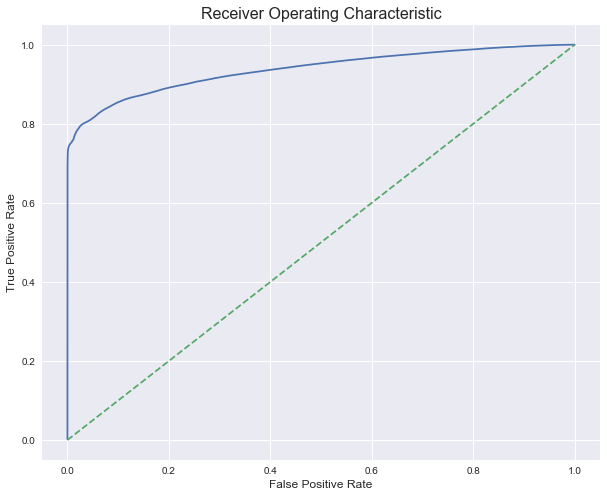

In [11]:
# Visualize precision and recall using ROC curve

from sklearn.metrics import roc_curve, roc_auc_score

y_prob = lr.predict_proba(X_train)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train, y_prob)

plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic', fontsize=16)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls='--')
plt.ylabel('True Positive Rate', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.show()

In [12]:
# Calculate the area under the curve using AUROC score
# The estimated probability that a uniformly drawn random positive is ranked before a uniformly drawn random negative.
ras = roc_auc_score(y_train, y_prob)
print("The AUROC score is {:.1f}%.".format(ras*100))

The AUROC score is 93.7%.


Logistic:
	Brier: 0.144
	Precision: 1.000
	Recall: 0.627
	F1: 0.771

Naive Bayes:
	Brier: 0.226
	Precision: 0.945
	Recall: 0.486
	F1: 0.642

Naive Bayes + Isotonic:
	Brier: 0.190
	Precision: 0.932
	Recall: 0.583
	F1: 0.717

Naive Bayes + Sigmoid:
	Brier: 0.191
	Precision: 0.738
	Recall: 0.727
	F1: 0.733

Logistic:
	Brier: 0.144
	Precision: 1.000
	Recall: 0.627
	F1: 0.771

SVC:
	Brier: 0.540
	Precision: 1.000
	Recall: 0.659
	F1: 0.794

SVC + Isotonic:
	Brier: 0.134
	Precision: 1.000
	Recall: 0.690
	F1: 0.817

SVC + Sigmoid:
	Brier: 0.138
	Precision: 1.000
	Recall: 0.658
	F1: 0.794



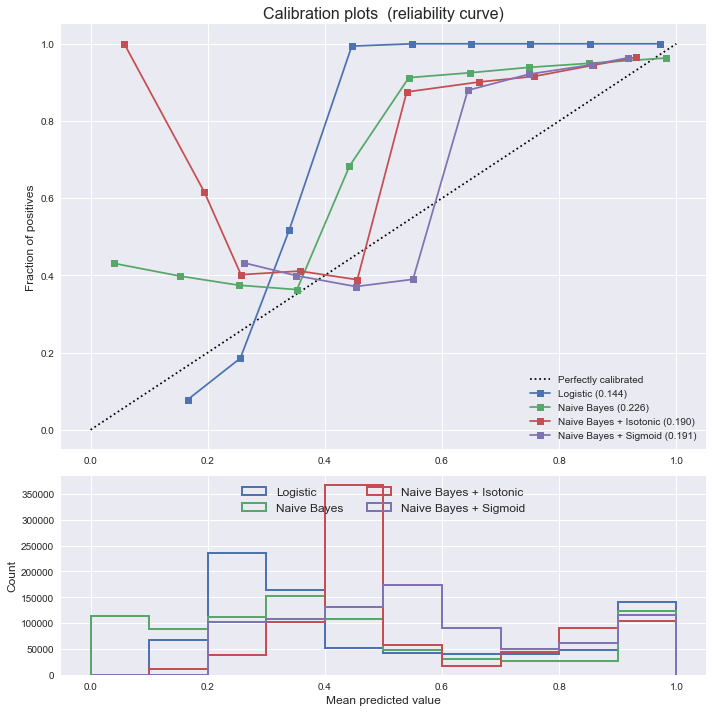

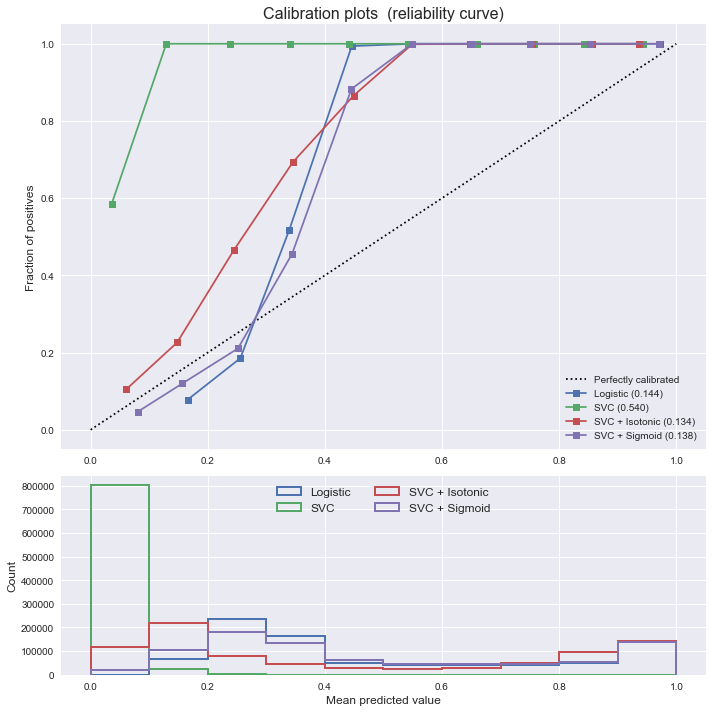

In [14]:
# Probability Calibration Curves
# copied from http://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score, f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_prior, y_prior)
        y_pred = clf.predict(X_train)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_train)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_train)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_train, prob_pos, pos_label=y_train.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_train, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_train, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_train, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_train, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives", fontsize=12)
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)', fontsize=16)

    ax2.set_xlabel("Mean predicted value", fontsize=12)
    ax2.set_ylabel("Count", fontsize=12)
    ax2.legend(loc="upper center", ncol=2, fontsize=12)

    plt.tight_layout()

# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)

# Plot calibration curve for Linear SVC
plot_calibration_curve(LinearSVC(), "SVC", 2)

plt.show()